# Lecture et nettoyage des données

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import os

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

## Importation des données

On lit les données d'apprentissage et de test et on forme une liste de toutes les données contenant au total 428 vols.

In [11]:
path_appr = "../Donnees_projet/Ensemble_apprentissage/"
path_test = "../Donnees_projet/Ensemble_test/"
#path_appr = "../../4A/Projet/Ensemble d'apprentissage/"
#path_test = "../../4A/Projet/Ensemble de test/"

In [12]:
# Liste des séries d'apprentissage
files = os.listdir(path_appr)
liste_appr = [pd.read_csv(path_appr + file) for file in files]
# Liste des séries de test
files = os.listdir(path_test)
liste_test = [pd.read_csv(path_test + file) for file in files]
# Liste complète
liste_comp = liste_appr + liste_test
n = len(liste_comp)

## Visualisation et retraitement des données

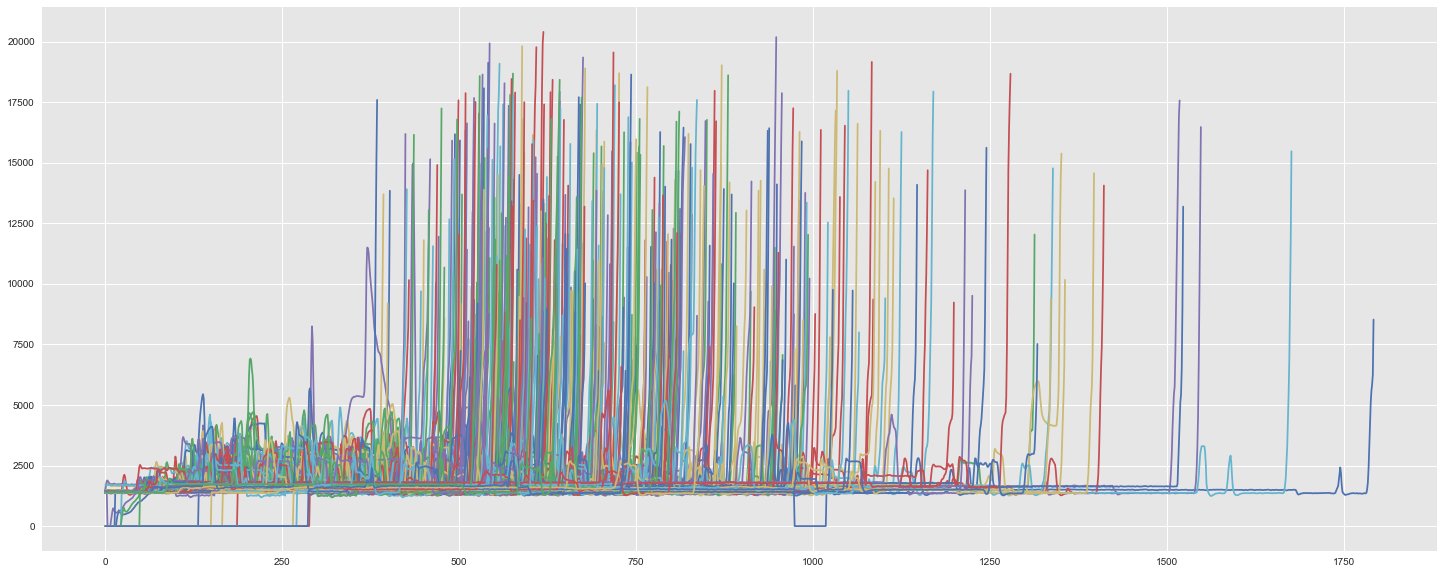

In [13]:
fig = plt.figure(figsize=(25, 10))
for data in liste_comp :
    plt.plot(data["FF_1"])
plt.show()

On observe que toutes les séries se terminent par un fort pic. On fait le choix de l'enlever car il n'apporte rien de significatif et risque de perturber l'analyse.

In [14]:
def enlever_pic(serie, seuil=10, pts_moy=2, plot=False) :
    """Retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. Les accroissements sont moyennés sur plusieurs points pour ne pas être sensibles 
    aux possibles irrégularités dans le pic.
    L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne le dataframe tronqué"""

    val_serie = serie["FF_1"].values
    if plot :
        plt.plot(val_serie)
        
    accr = abs(val_serie[1:] - val_serie[:-1])
    moy_accr = [np.mean(accr[i : i + pts_moy]) for i in range(len(accr) - pts_moy)]

    for ind, val in enumerate(moy_accr[::-1]) :
        if val < seuil and ind >= 1 :
            if plot :
                plt.plot(val_serie[:-ind], color="red")
                plt.show()
                
            return serie.drop(serie.index[-ind:])
            break
    else : 
        return serie

In [15]:
liste_comp = [enlever_pic(serie) for serie in liste_comp]

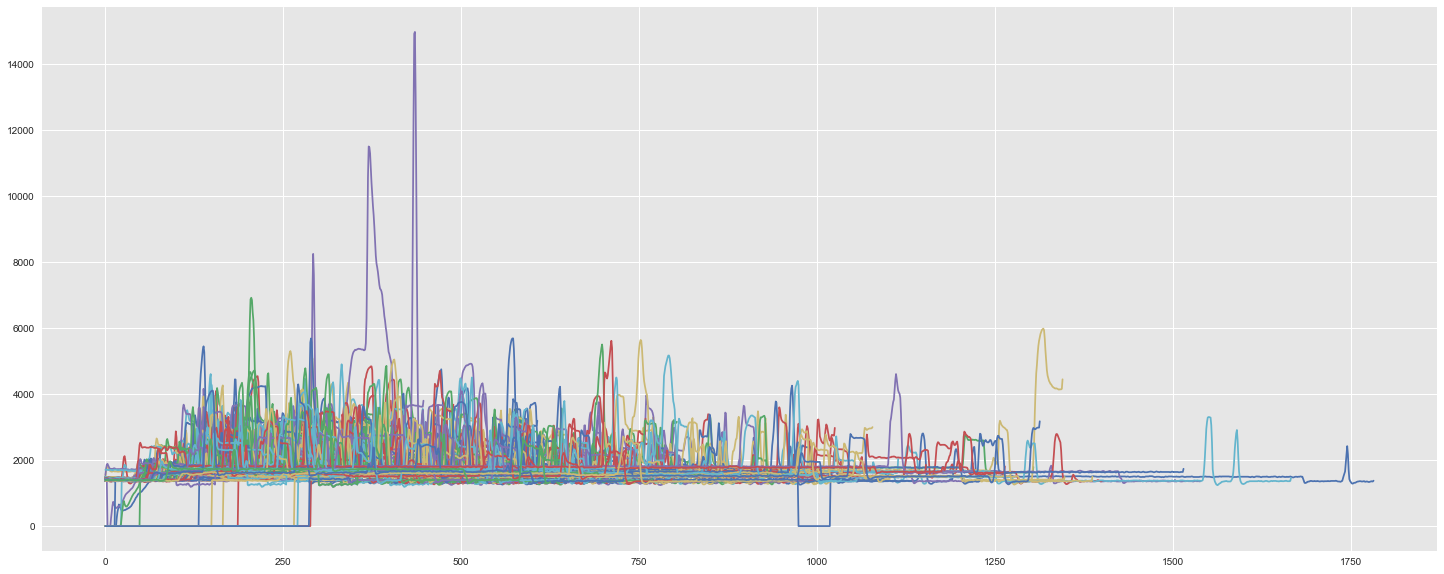

In [16]:
fig = plt.figure(figsize=(25, 10))
for data in liste_comp :
    plt.plot(data["FF_1"])
    
plt.show()

On peut voir qu'on a bien retiré tous les pics finaux.

Longueur des séries sans pic :

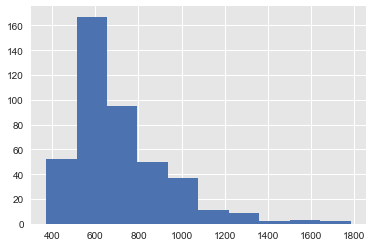

372


In [17]:
long = [serie.shape[0] for serie in liste_comp]
plt.hist(long)
plt.show()
longueur_min = min(long)
print(longueur_min)

In [18]:
X = [list(serie["FF_1"].values) for serie in liste_comp]